# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [3]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def vgg_max_pooling_layer(input_layer) :
    output_layer = layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2))(input_layer)
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [4]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [5]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides=strides)
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [6]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    upsampled_layer = bilinear_upsample(small_ip_layer)
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    output_layer = layers.concatenate([upsampled_layer, large_ip_layer])
    # TODO Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(output_layer, filters)
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [7]:
def fcn_model_base(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    output_layer = encoder_block(inputs, 64, 2)
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    small_ip_layer = conv2d_batchnorm(output_layer, 64, kernel_size=1, strides=1)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    x = decoder_block(small_ip_layer, inputs, 64)
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)

In [8]:
def fcn_model_var1(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    conv1 = encoder_block(inputs, 32, 2)
    conv2 = encoder_block(conv1, 64, 2)
    conv3 = encoder_block(conv2, 128, 2)
    
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    conv_norm = conv2d_batchnorm(conv3, 256, kernel_size=1, strides=1)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    deconv1 = decoder_block(conv_norm, conv2, 128)
    deconv2 = decoder_block(deconv1, conv1, 64)
    x = decoder_block(deconv2, inputs, 32)
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)

In [9]:
def fcn_model_var2(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    conv1 = encoder_block(inputs, 32, 2)
    conv2 = encoder_block(conv1, 64, 2)
    conv3 = encoder_block(conv2, 128, 2)
    conv4 = encoder_block(conv3, 256, 2)
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    conv_norm = conv2d_batchnorm(conv4, 512, kernel_size=1, strides=1)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    deconv1 = decoder_block(conv_norm, conv3, 256)
    deconv2 = decoder_block(deconv1, conv2, 128)
    deconv3 = decoder_block(deconv2, conv1, 64)
    x = decoder_block(deconv3, inputs, 32)
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)

In [325]:
def fcn_model_var3(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    conv1 = encoder_block(inputs, 32, 2)
    conv2 = encoder_block(conv1, 64, 2)
    
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    conv_norm = conv2d_batchnorm(conv2, 128, kernel_size=1, strides=1)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    deconv1 = decoder_block(conv_norm, conv1, 64)
    x = decoder_block(deconv1, inputs, 32)
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)

In [10]:
def fcn_model_vgg(inputs, num_classes) :
    conv1 = encoder_block(inputs, 32, 1)
    pool1 = vgg_max_pooling_layer(conv1)
    
    conv2 = encoder_block(pool1, 64, 1)
    pool2 = vgg_max_pooling_layer( conv2)
    
    conv3 = encoder_block(pool2, 128, 1)
    conv4 = encoder_block(conv3, 128, 1)
    pool3 = vgg_max_pooling_layer( conv4)
    
    conv5 = encoder_block(pool3, 256, 1)
    conv6 = encoder_block(conv5, 256, 1)
    pool4 = vgg_max_pooling_layer( conv6)
    
    conv7 = encoder_block(pool4, 256, 1)
    conv8 = encoder_block(conv7, 256, 1)
    pool5 = vgg_max_pooling_layer( conv8)
    
    mid = conv2d_batchnorm(pool5, 512, 1)
    
    deconv1 = decoder_block(mid, pool4, 256)
    deconv2 = decoder_block(deconv1, pool3, 256)
    deconv3 = decoder_block(deconv2, pool2, 128)
    deconv4 = decoder_block(deconv3, pool1, 64)
    
    x = decoder_block(deconv4, inputs, 32 )
    return layers.Conv2D(num_classes, 3, activation = 'softmax', padding = 'same')(x)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model_var1(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [13]:
learning_rate = 0.001
batch_size = 64
num_epochs = 30
steps_per_epoch = 120
validation_steps = 20
workers = 2

In [14]:
import time
start = time.time()

In [15]:
output_layer = fcn_model_vgg(inputs, num_classes)

Epoch 1/30
119/120 [============================>.] - ETA: 0s - loss: 0.4960

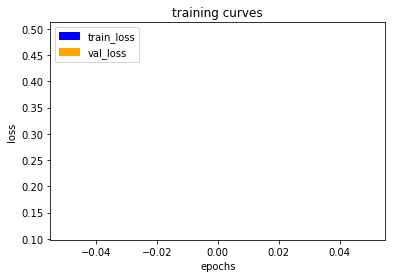

120/120 [==============================] - 79s - loss: 0.4925 - val_loss: 0.1171
Epoch 2/30
119/120 [============================>.] - ETA: 0s - loss: 0.0460

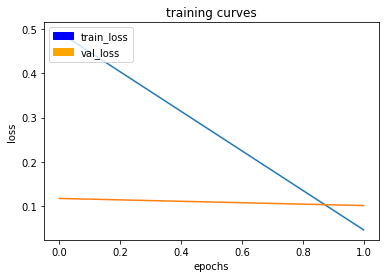

120/120 [==============================] - 76s - loss: 0.0459 - val_loss: 0.1010
Epoch 3/30
119/120 [============================>.] - ETA: 0s - loss: 0.0293

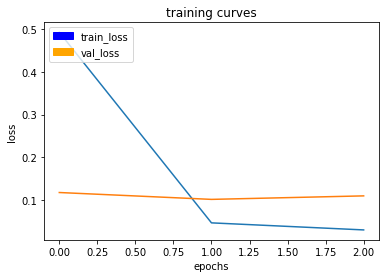

120/120 [==============================] - 77s - loss: 0.0293 - val_loss: 0.1092
Epoch 4/30
119/120 [============================>.] - ETA: 0s - loss: 0.0226

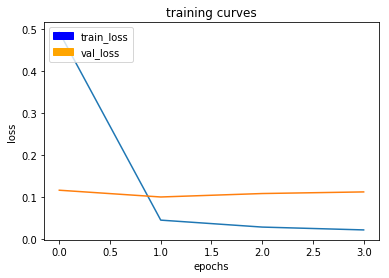

120/120 [==============================] - 78s - loss: 0.0225 - val_loss: 0.1130
Epoch 5/30
119/120 [============================>.] - ETA: 0s - loss: 0.0225

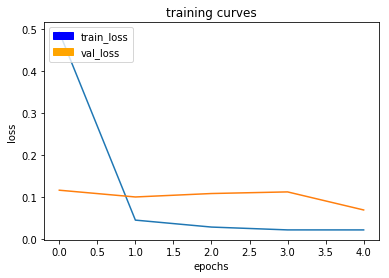

120/120 [==============================] - 78s - loss: 0.0225 - val_loss: 0.0700
Epoch 6/30
119/120 [============================>.] - ETA: 0s - loss: 0.0209

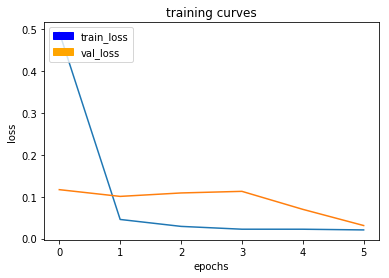

120/120 [==============================] - 77s - loss: 0.0208 - val_loss: 0.0313
Epoch 7/30
119/120 [============================>.] - ETA: 0s - loss: 0.0166

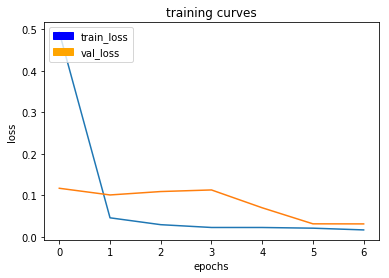

120/120 [==============================] - 78s - loss: 0.0167 - val_loss: 0.0312
Epoch 8/30
119/120 [============================>.] - ETA: 0s - loss: 0.0156

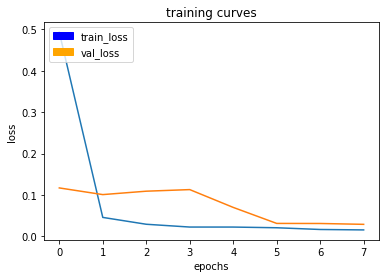

120/120 [==============================] - 78s - loss: 0.0156 - val_loss: 0.0291
Epoch 9/30
119/120 [============================>.] - ETA: 0s - loss: 0.0144

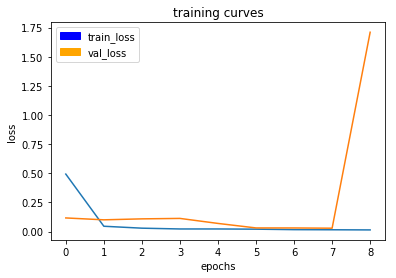

120/120 [==============================] - 77s - loss: 0.0144 - val_loss: 1.7101
Epoch 10/30
119/120 [============================>.] - ETA: 0s - loss: 0.0200

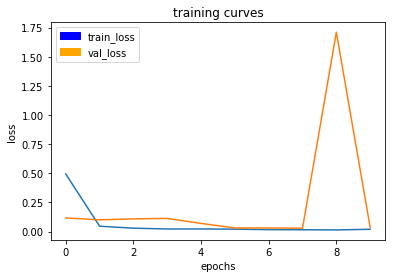

120/120 [==============================] - 77s - loss: 0.0199 - val_loss: 0.0365
Epoch 11/30
119/120 [============================>.] - ETA: 0s - loss: 0.0166

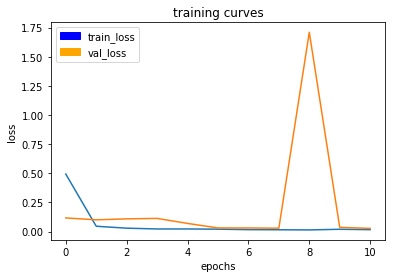

120/120 [==============================] - 78s - loss: 0.0166 - val_loss: 0.0274
Epoch 12/30
119/120 [============================>.] - ETA: 0s - loss: 0.0195

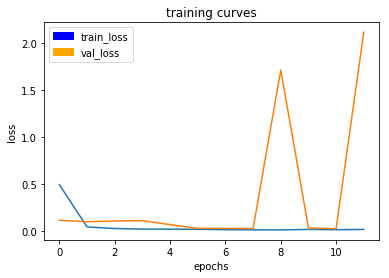

120/120 [==============================] - 78s - loss: 0.0196 - val_loss: 2.1107
Epoch 13/30
119/120 [============================>.] - ETA: 0s - loss: 0.0221

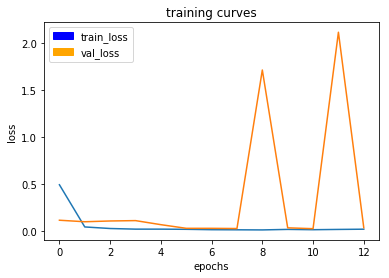

120/120 [==============================] - 78s - loss: 0.0220 - val_loss: 0.0380
Epoch 14/30
119/120 [============================>.] - ETA: 0s - loss: 0.0159

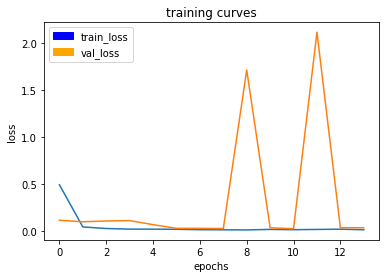

120/120 [==============================] - 78s - loss: 0.0159 - val_loss: 0.0375
Epoch 15/30
119/120 [============================>.] - ETA: 0s - loss: 0.0391

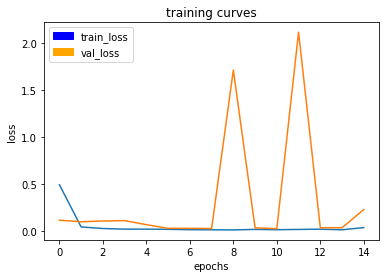

120/120 [==============================] - 78s - loss: 0.0390 - val_loss: 0.2306
Epoch 16/30
119/120 [============================>.] - ETA: 0s - loss: 0.0238

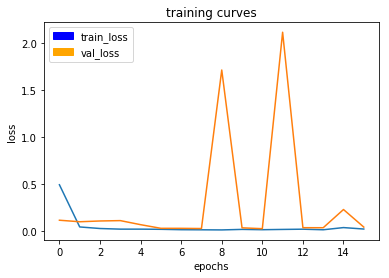

120/120 [==============================] - 78s - loss: 0.0238 - val_loss: 0.0443
Epoch 17/30
119/120 [============================>.] - ETA: 0s - loss: 0.0199

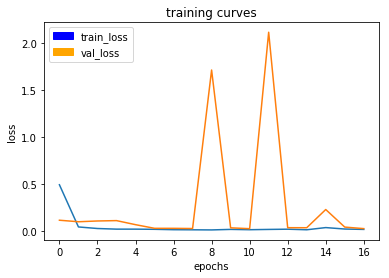

120/120 [==============================] - 77s - loss: 0.0199 - val_loss: 0.0281
Epoch 18/30
119/120 [============================>.] - ETA: 0s - loss: 0.0179

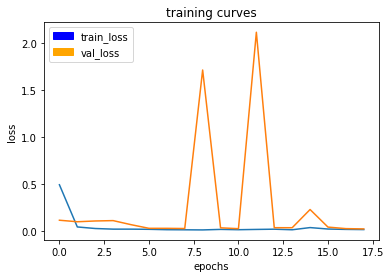

120/120 [==============================] - 77s - loss: 0.0179 - val_loss: 0.0250
Epoch 19/30
119/120 [============================>.] - ETA: 0s - loss: 0.0169

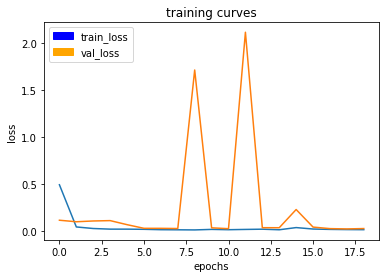

120/120 [==============================] - 77s - loss: 0.0169 - val_loss: 0.0288
Epoch 20/30
119/120 [============================>.] - ETA: 0s - loss: 0.0153

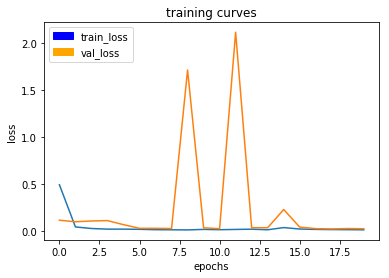

120/120 [==============================] - 77s - loss: 0.0153 - val_loss: 0.0270
Epoch 21/30
119/120 [============================>.] - ETA: 0s - loss: 0.0147

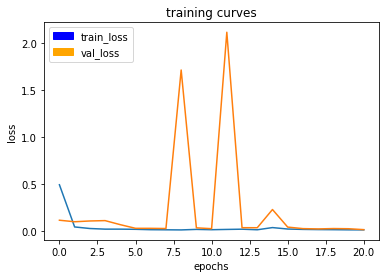

120/120 [==============================] - 78s - loss: 0.0146 - val_loss: 0.0173
Epoch 22/30
119/120 [============================>.] - ETA: 0s - loss: 0.0147

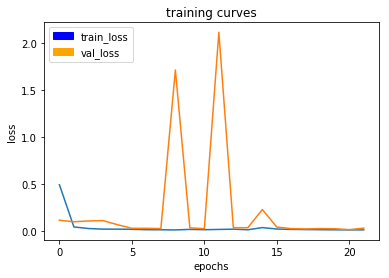

120/120 [==============================] - 77s - loss: 0.0147 - val_loss: 0.0335
Epoch 23/30
119/120 [============================>.] - ETA: 0s - loss: 0.0136

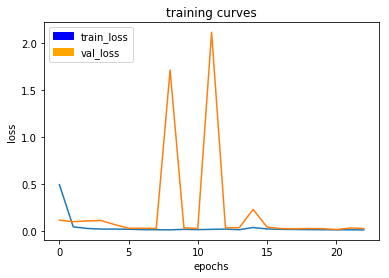

120/120 [==============================] - 78s - loss: 0.0136 - val_loss: 0.0280
Epoch 24/30
119/120 [============================>.] - ETA: 0s - loss: 0.0131

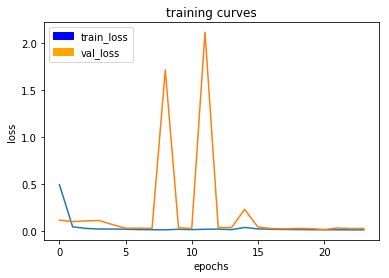

120/120 [==============================] - 78s - loss: 0.0131 - val_loss: 0.0284
Epoch 25/30
119/120 [============================>.] - ETA: 0s - loss: 0.0128

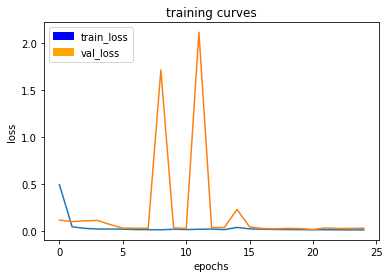

120/120 [==============================] - 78s - loss: 0.0128 - val_loss: 0.0308
Epoch 26/30
119/120 [============================>.] - ETA: 0s - loss: 0.0124

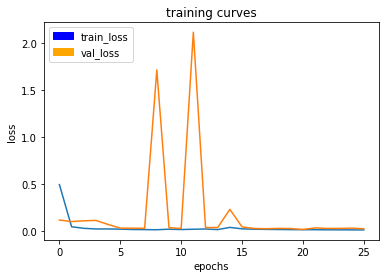

120/120 [==============================] - 78s - loss: 0.0124 - val_loss: 0.0245
Epoch 27/30
119/120 [============================>.] - ETA: 0s - loss: 0.0124

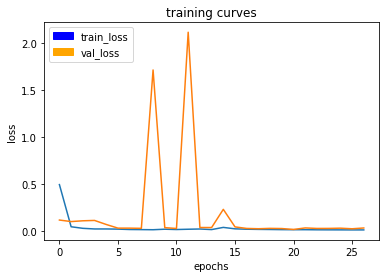

120/120 [==============================] - 77s - loss: 0.0124 - val_loss: 0.0329
Epoch 28/30
119/120 [============================>.] - ETA: 0s - loss: 0.0121

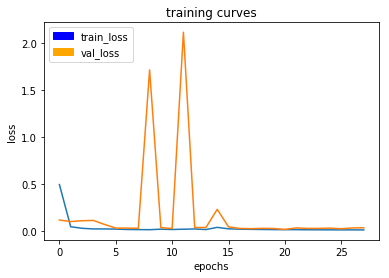

120/120 [==============================] - 77s - loss: 0.0120 - val_loss: 0.0350
Epoch 29/30
119/120 [============================>.] - ETA: 0s - loss: 0.0118

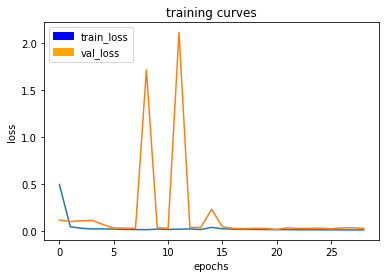

120/120 [==============================] - 77s - loss: 0.0118 - val_loss: 0.0282
Epoch 30/30
119/120 [============================>.] - ETA: 0s - loss: 0.0115

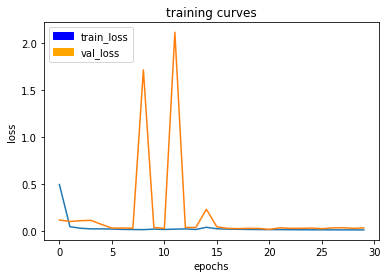

120/120 [==============================] - 78s - loss: 0.0115 - val_loss: 0.0327


In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train_combined_o'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation_o'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [17]:
end = time.time()

In [18]:
print(end - start)

2345.7334382534027


In [31]:
# Save your trained model weights
weight_file_name = 'model_weights_lr_001_bs_64_e30_spe_120_vs_20_run_1.h5'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [32]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [33]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

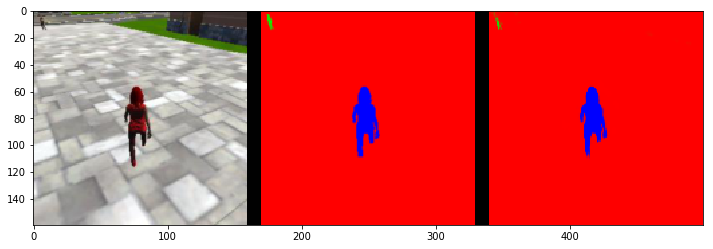

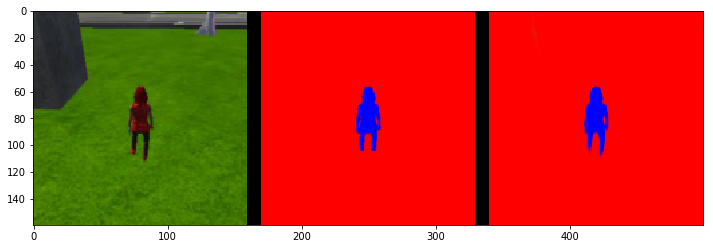

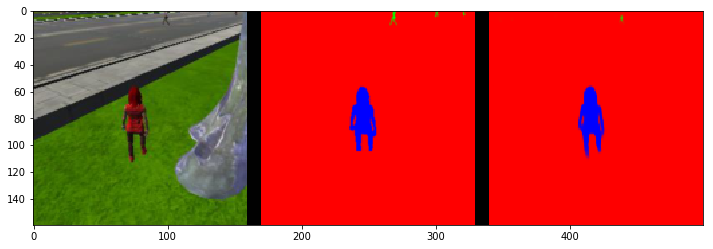

In [34]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

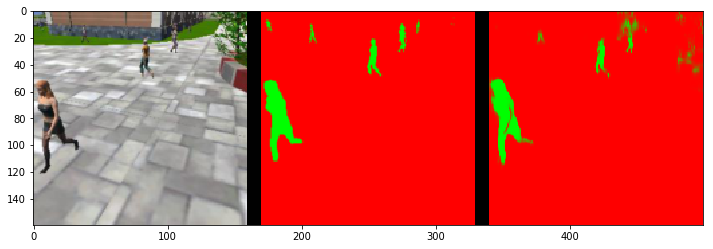

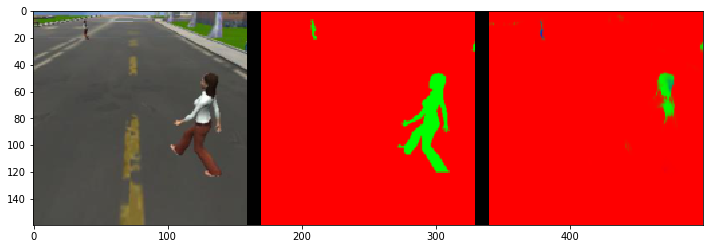

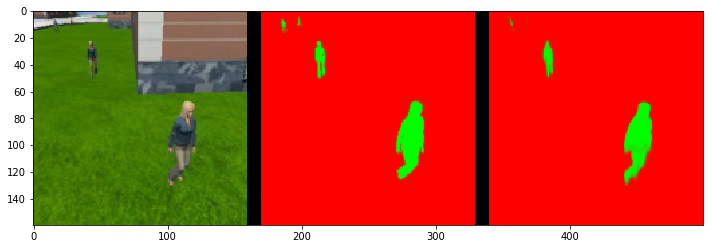

In [35]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

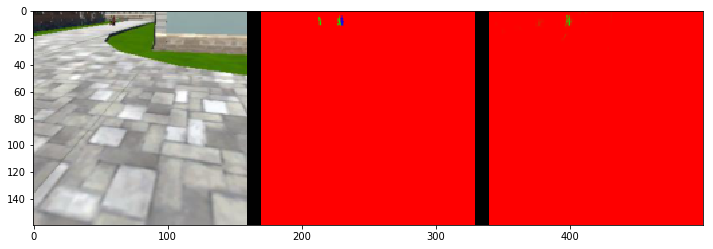

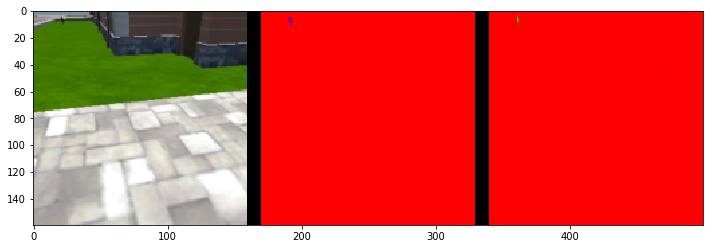

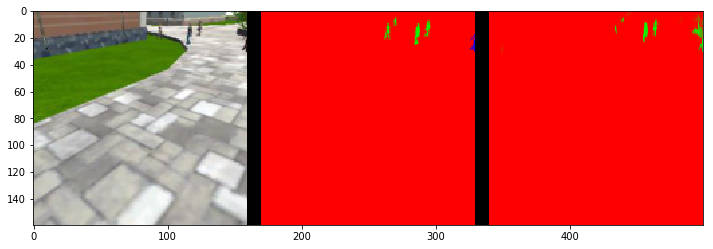

In [36]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [37]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9956130650231355
average intersection over union for other people is 0.3512304142859153
average intersection over union for the hero is 0.8973898323889773
number true positives: 539, number false positives: 0, number false negatives: 0


In [38]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9896241801712514
average intersection over union for other people is 0.7886965534573893
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 19, number false negatives: 0


In [39]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9966072683714445
average intersection over union for other people is 0.4325896258440642
average intersection over union for the hero is 0.19563901707972847
number true positives: 109, number false positives: 0, number false negatives: 192


In [40]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7543655413271245


In [41]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.5465144247343529


In [42]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.4122716498578121


In [43]:
learning_rate = 0.005
batch_size = 64
num_epochs = 10
steps_per_epoch = 150
validation_steps = 40
workers = 2

In [44]:
import time
start = time.time()

In [45]:
output_layer = fcn_model_vgg(inputs, num_classes)

Epoch 1/10
149/150 [============================>.] - ETA: 0s - loss: 0.1601

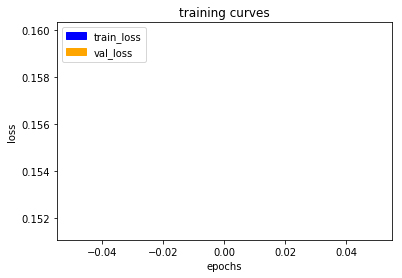

150/150 [==============================] - 97s - loss: 0.1592 - val_loss: 0.1515
Epoch 2/10
149/150 [============================>.] - ETA: 0s - loss: 0.0320

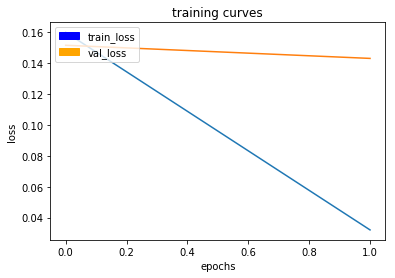

150/150 [==============================] - 99s - loss: 0.0320 - val_loss: 0.1430
Epoch 3/10
149/150 [============================>.] - ETA: 0s - loss: 0.0251

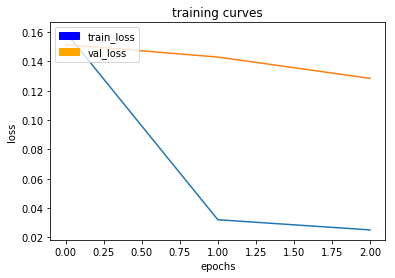

150/150 [==============================] - 99s - loss: 0.0251 - val_loss: 0.1285
Epoch 4/10
149/150 [============================>.] - ETA: 0s - loss: 0.0224

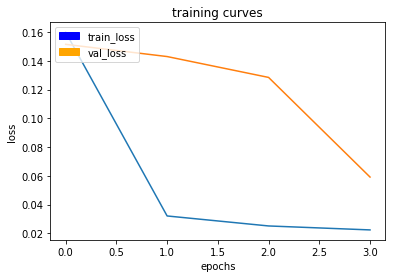

150/150 [==============================] - 99s - loss: 0.0223 - val_loss: 0.0591
Epoch 5/10
149/150 [============================>.] - ETA: 0s - loss: 0.0204

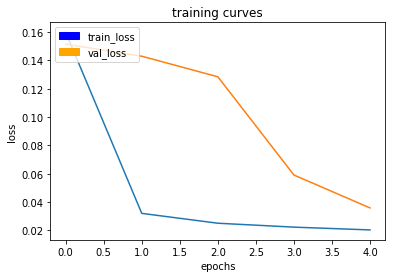

150/150 [==============================] - 100s - loss: 0.0204 - val_loss: 0.0359
Epoch 6/10
149/150 [============================>.] - ETA: 0s - loss: 0.0203

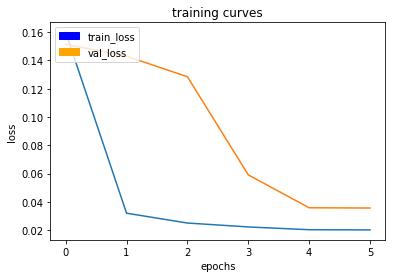

150/150 [==============================] - 99s - loss: 0.0202 - val_loss: 0.0357
Epoch 7/10
149/150 [============================>.] - ETA: 0s - loss: 0.0187

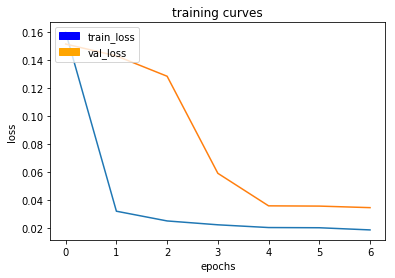

150/150 [==============================] - 99s - loss: 0.0187 - val_loss: 0.0346
Epoch 8/10
149/150 [============================>.] - ETA: 0s - loss: 0.0165

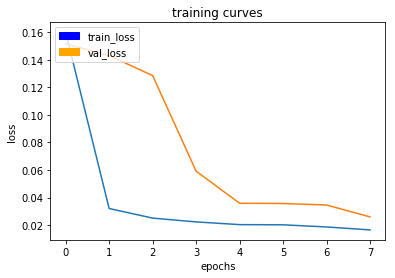

150/150 [==============================] - 99s - loss: 0.0165 - val_loss: 0.0260
Epoch 9/10
149/150 [============================>.] - ETA: 0s - loss: 0.0144

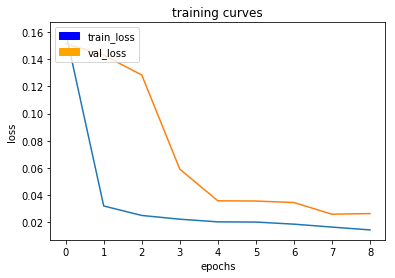

150/150 [==============================] - 99s - loss: 0.0144 - val_loss: 0.0265
Epoch 10/10
149/150 [============================>.] - ETA: 0s - loss: 0.0129

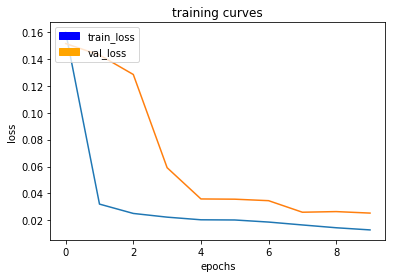

150/150 [==============================] - 99s - loss: 0.0128 - val_loss: 0.0254


In [46]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train_combined_o'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation_o'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [47]:
end = time.time()

In [48]:
print(end - start)

999.5520370006561


In [49]:
# Save your trained model weights
weight_file_name = 'model_weights_lr_005_bs_64_e10_spe_150_vs_40_run_2.h5'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [50]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [51]:
run_num = 'run_2'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

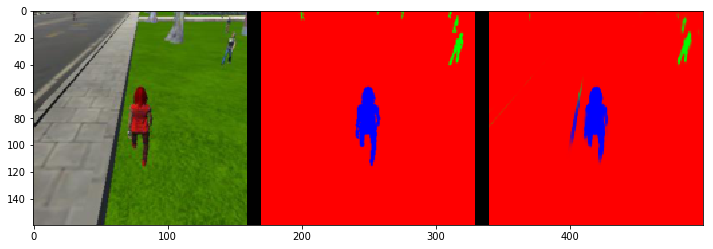

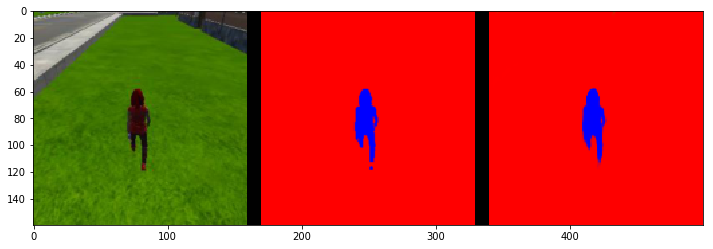

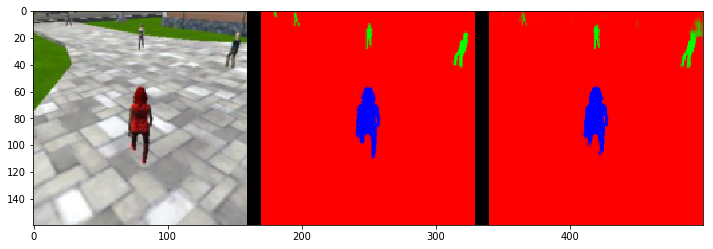

In [52]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

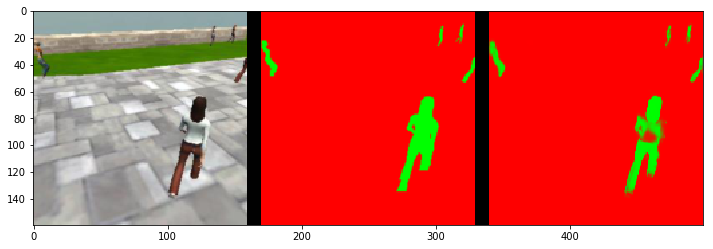

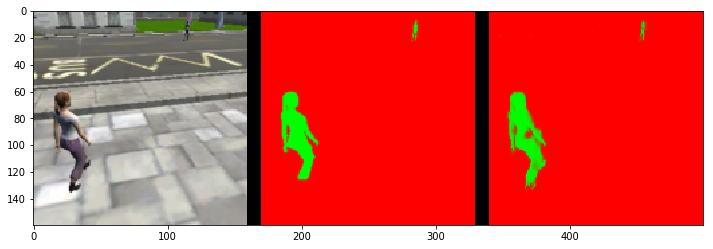

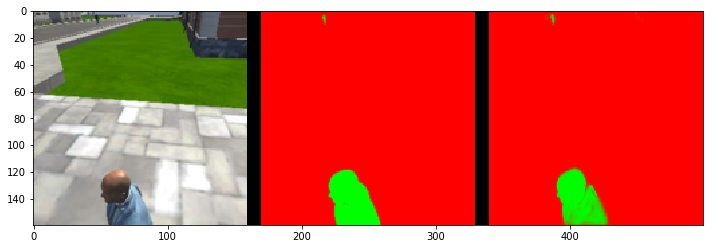

In [53]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

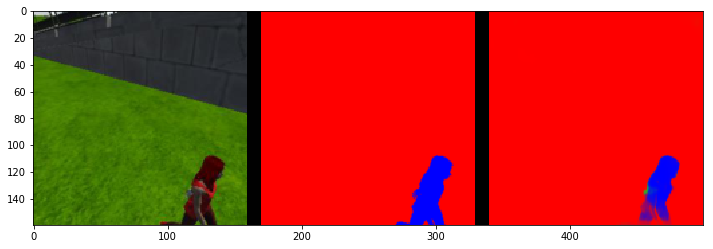

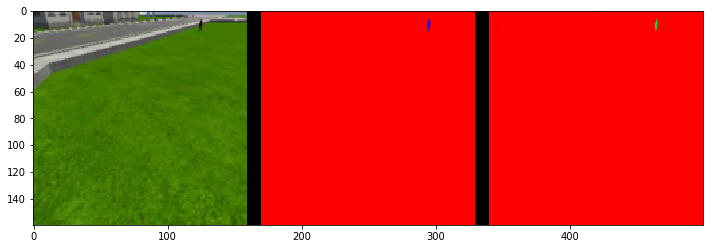

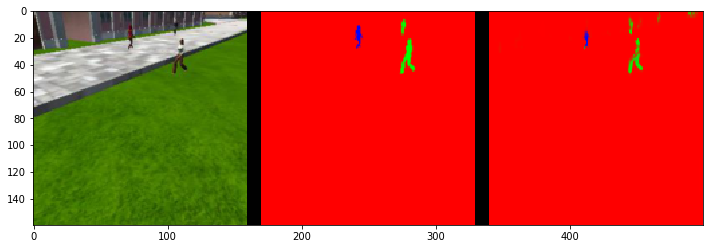

In [54]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [55]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9957060597529372
average intersection over union for other people is 0.37819179590277147
average intersection over union for the hero is 0.911164449234461
number true positives: 539, number false positives: 0, number false negatives: 0


In [56]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9896640684427059
average intersection over union for other people is 0.7996321115840819
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 17, number false negatives: 0


In [57]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9969127481559359
average intersection over union for other people is 0.4615751050307975
average intersection over union for the hero is 0.22296034869060313
number true positives: 124, number false positives: 0, number false negatives: 177


In [58]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7736289381563594


In [59]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.5670623989625321


In [60]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.4386958815777815


In [301]:
learning_rate = 0.005
batch_size = 64
num_epochs = 20
steps_per_epoch = 150
validation_steps = 40
workers = 2

In [302]:
import time
start = time.time()

In [303]:
output_layer = fcn_model_vgg(inputs, num_classes)

Epoch 1/20
149/150 [============================>.] - ETA: 0s - loss: 0.1605

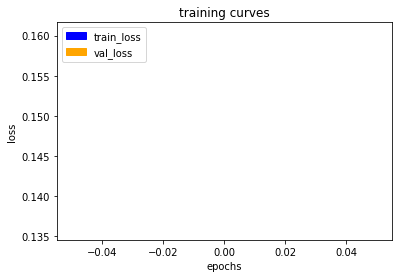

150/150 [==============================] - 98s - loss: 0.1597 - val_loss: 0.1357
Epoch 2/20
149/150 [============================>.] - ETA: 0s - loss: 0.0303

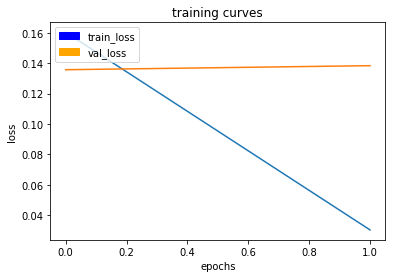

150/150 [==============================] - 99s - loss: 0.0303 - val_loss: 0.1384
Epoch 3/20
149/150 [============================>.] - ETA: 0s - loss: 0.0241

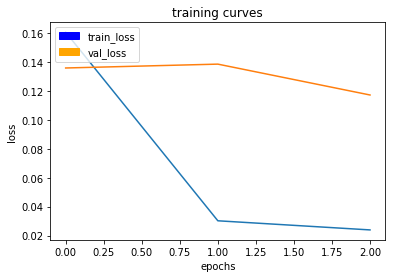

150/150 [==============================] - 100s - loss: 0.0240 - val_loss: 0.1171
Epoch 4/20
149/150 [============================>.] - ETA: 0s - loss: 0.0214

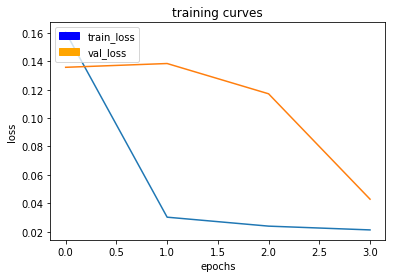

150/150 [==============================] - 99s - loss: 0.0214 - val_loss: 0.0429
Epoch 5/20
149/150 [============================>.] - ETA: 0s - loss: 0.0205

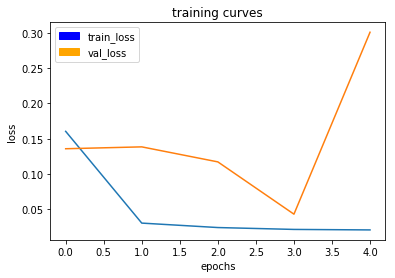

150/150 [==============================] - 100s - loss: 0.0206 - val_loss: 0.3010
Epoch 6/20
149/150 [============================>.] - ETA: 0s - loss: 0.0242

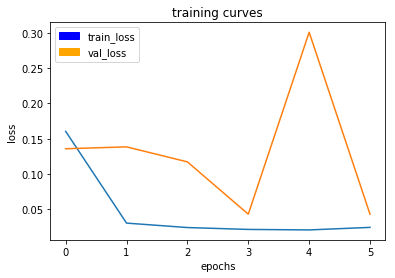

150/150 [==============================] - 99s - loss: 0.0242 - val_loss: 0.0428
Epoch 7/20
149/150 [============================>.] - ETA: 0s - loss: 0.0170

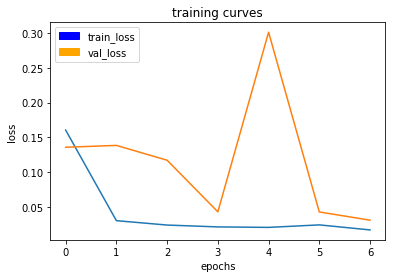

150/150 [==============================] - 99s - loss: 0.0170 - val_loss: 0.0309
Epoch 8/20
149/150 [============================>.] - ETA: 0s - loss: 0.0145

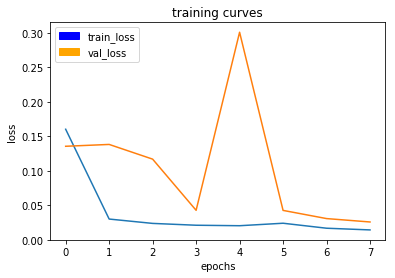

150/150 [==============================] - 100s - loss: 0.0145 - val_loss: 0.0260
Epoch 9/20
149/150 [============================>.] - ETA: 0s - loss: 0.0132

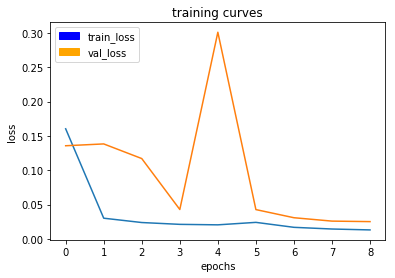

150/150 [==============================] - 100s - loss: 0.0132 - val_loss: 0.0253
Epoch 10/20
149/150 [============================>.] - ETA: 0s - loss: 0.0123

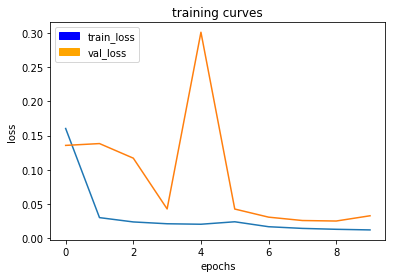

150/150 [==============================] - 99s - loss: 0.0123 - val_loss: 0.0329
Epoch 11/20
149/150 [============================>.] - ETA: 0s - loss: 0.0117

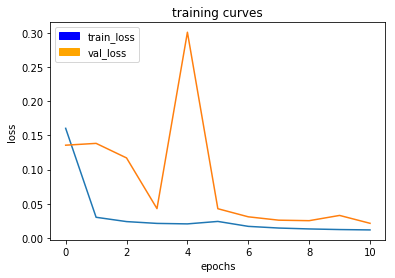

150/150 [==============================] - 100s - loss: 0.0117 - val_loss: 0.0214
Epoch 12/20
149/150 [============================>.] - ETA: 0s - loss: 0.0195

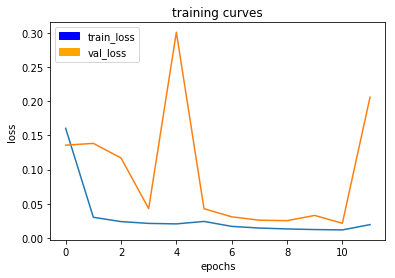

150/150 [==============================] - 99s - loss: 0.0195 - val_loss: 0.2060
Epoch 13/20
149/150 [============================>.] - ETA: 0s - loss: 0.0168

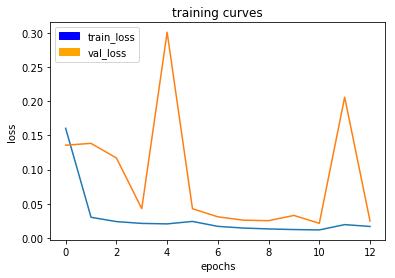

150/150 [==============================] - 100s - loss: 0.0168 - val_loss: 0.0247
Epoch 14/20
149/150 [============================>.] - ETA: 0s - loss: 0.0131

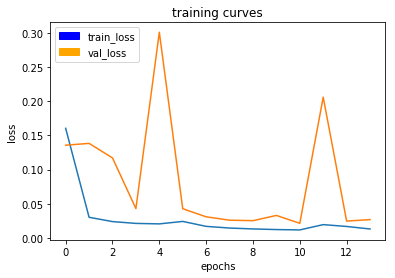

150/150 [==============================] - 100s - loss: 0.0131 - val_loss: 0.0268
Epoch 15/20
149/150 [============================>.] - ETA: 0s - loss: 0.0117

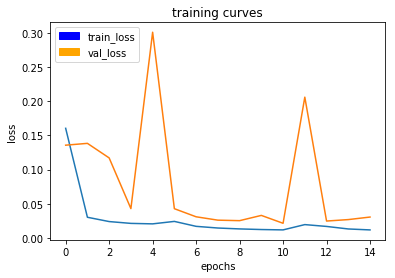

150/150 [==============================] - 100s - loss: 0.0117 - val_loss: 0.0305
Epoch 16/20
149/150 [============================>.] - ETA: 0s - loss: 0.0110

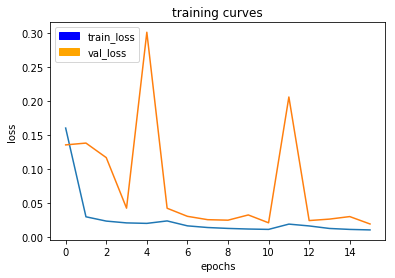

150/150 [==============================] - 100s - loss: 0.0110 - val_loss: 0.0197
Epoch 17/20
149/150 [============================>.] - ETA: 0s - loss: 0.0106

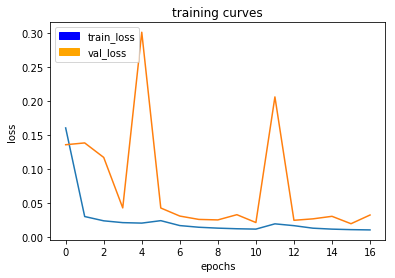

150/150 [==============================] - 100s - loss: 0.0106 - val_loss: 0.0325
Epoch 18/20
149/150 [============================>.] - ETA: 0s - loss: 0.0102

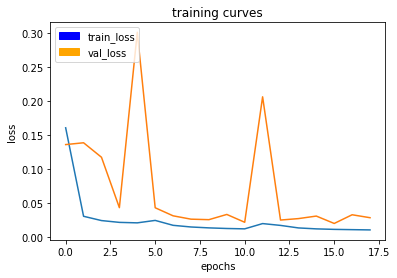

150/150 [==============================] - 99s - loss: 0.0102 - val_loss: 0.0281
Epoch 19/20
149/150 [============================>.] - ETA: 0s - loss: 0.0100

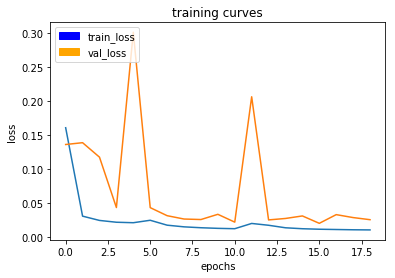

150/150 [==============================] - 99s - loss: 0.0100 - val_loss: 0.0250
Epoch 20/20
149/150 [============================>.] - ETA: 0s - loss: 0.0101

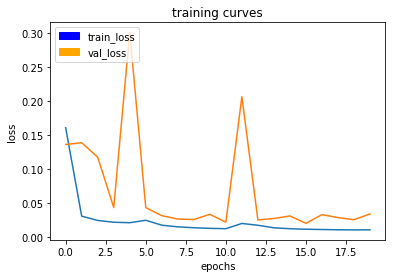

150/150 [==============================] - 99s - loss: 0.0101 - val_loss: 0.0335


In [304]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train_combined_o'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation_o'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [305]:
end = time.time()

In [306]:
print(end - start)

2002.777186870575


In [307]:
# Save your trained model weights
weight_file_name = 'model_weights_lr_005_bs_64_e20_spe_150_vs_40_run_3.h5'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [308]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [309]:
run_num = 'run_3'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

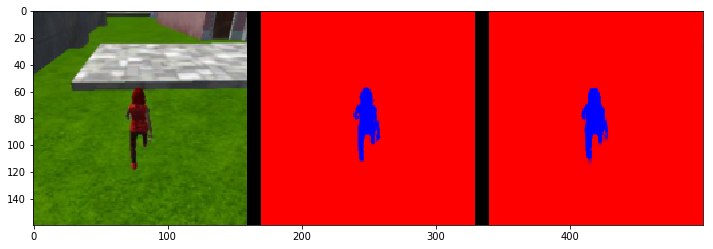

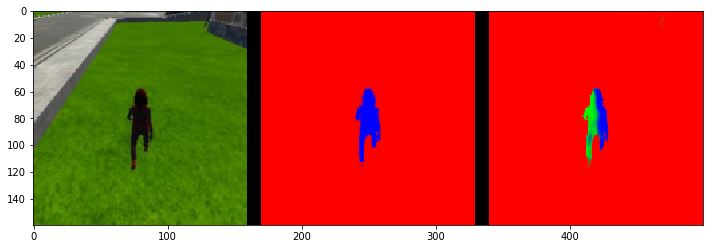

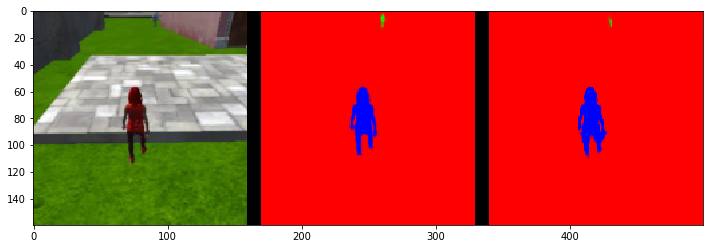

In [310]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

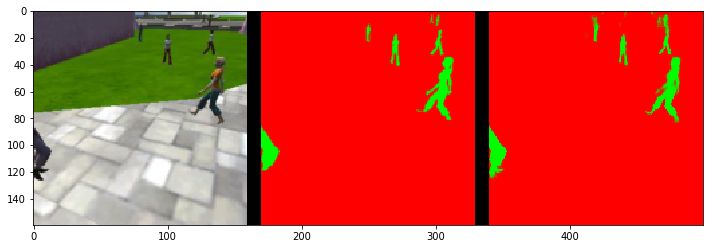

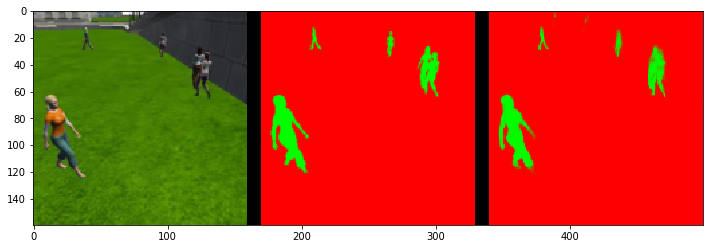

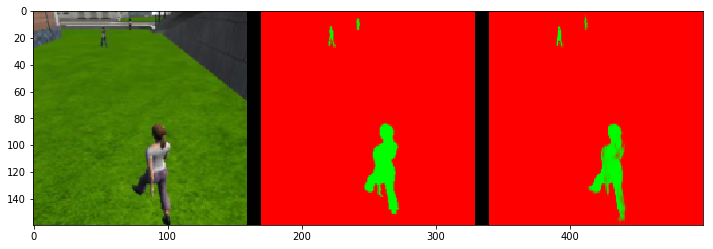

In [311]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

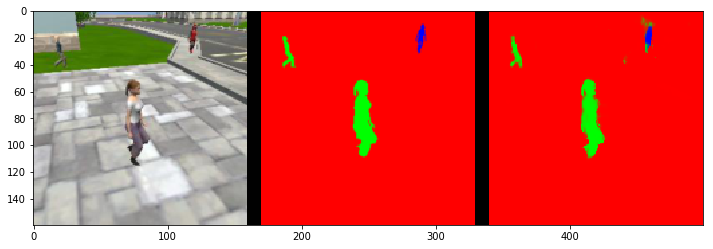

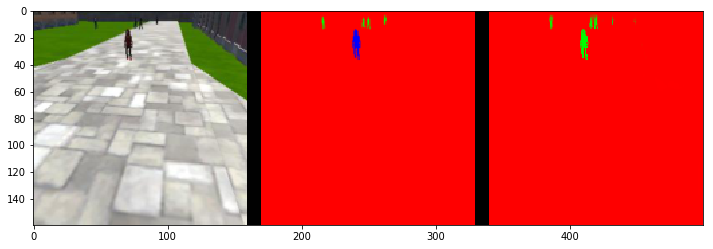

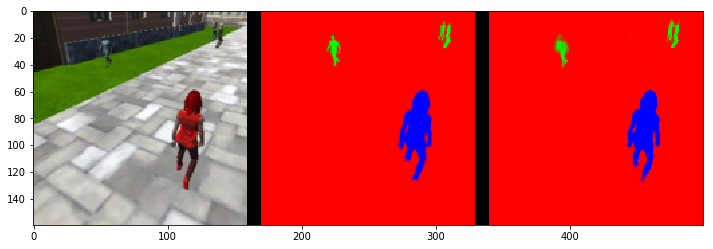

In [312]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [313]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9960480063761674
average intersection over union for other people is 0.40062473821686034
average intersection over union for the hero is 0.9150261478449879
number true positives: 539, number false positives: 0, number false negatives: 0


In [314]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9904106610753152
average intersection over union for other people is 0.8047710809852892
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 39, number false negatives: 0


In [315]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9970577072399094
average intersection over union for other people is 0.4786325517494386
average intersection over union for the hero is 0.29430762219403206
number true positives: 155, number false positives: 1, number false negatives: 146


In [316]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7886363636363637


In [317]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.60466688501951


In [318]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.47686229341311365


In [320]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 160, 160, 3)       0         
_________________________________________________________________
separable_conv2d_keras_33 (S (None, 160, 160, 32)      155       
_________________________________________________________________
batch_normalization_36 (Batc (None, 160, 160, 32)      128       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 80, 80, 32)        0         
_________________________________________________________________
separable_conv2d_keras_34 (S (None, 80, 80, 64)        2400      
_________________________________________________________________
batch_normalization_37 (Batc (None, 80, 80, 64)        256       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 40, 40, 64)        0         
__________

In [322]:
output_layer = fcn_model_var1(inputs, num_classes)
model = models.Model(inputs=inputs, outputs=output_layer)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 160, 160, 3)       0         
_________________________________________________________________
separable_conv2d_keras_46 (S (None, 80, 80, 32)        155       
_________________________________________________________________
batch_normalization_50 (Batc (None, 80, 80, 32)        128       
_________________________________________________________________
separable_conv2d_keras_47 (S (None, 40, 40, 64)        2400      
_________________________________________________________________
batch_normalization_51 (Batc (None, 40, 40, 64)        256       
_________________________________________________________________
separable_conv2d_keras_48 (S (None, 20, 20, 128)       8896      
_________________________________________________________________
batch_normalization_52 (Batc (None, 20, 20, 128)       512       
__________

In [323]:
output_layer = fcn_model_var2(inputs, num_classes)
model = models.Model(inputs=inputs, outputs=output_layer)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 160, 160, 3)       0         
_________________________________________________________________
separable_conv2d_keras_52 (S (None, 80, 80, 32)        155       
_________________________________________________________________
batch_normalization_57 (Batc (None, 80, 80, 32)        128       
_________________________________________________________________
separable_conv2d_keras_53 (S (None, 40, 40, 64)        2400      
_________________________________________________________________
batch_normalization_58 (Batc (None, 40, 40, 64)        256       
_________________________________________________________________
separable_conv2d_keras_54 (S (None, 20, 20, 128)       8896      
_________________________________________________________________
batch_normalization_59 (Batc (None, 20, 20, 128)       512       
__________

In [326]:
output_layer = fcn_model_var3(inputs, num_classes)
model = models.Model(inputs=inputs, outputs=output_layer)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 160, 160, 3)       0         
_________________________________________________________________
separable_conv2d_keras_60 (S (None, 80, 80, 32)        155       
_________________________________________________________________
batch_normalization_66 (Batc (None, 80, 80, 32)        128       
_________________________________________________________________
separable_conv2d_keras_61 (S (None, 40, 40, 64)        2400      
_________________________________________________________________
batch_normalization_67 (Batc (None, 40, 40, 64)        256       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 40, 40, 128)       8320      
_________________________________________________________________
batch_normalization_68 (Batc (None, 40, 40, 128)       512       
__________